In [ ]:
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
genderList = ['Male', 'Female']

# Load network
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

padding = 20


def gender_detector(frame):
    global male_count, female_count
    male_count = 0
    female_count = 0

    # Read frame
    frameFace, bboxes = getFaceBox(faceNet, frame)
    for bbox in bboxes:
        face = frame[max(0, bbox[1] - padding):min(bbox[3] + padding, frame.shape[0] - 1),
                     max(0, bbox[0] - padding):min(bbox[2] + padding, frame.shape[1] - 1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        # Update gender counts
        if gender == 'Male':
            male_count += 1
        elif gender == 'Female':
            female_count += 1

        label = "{}".format(gender)
        cv.putText(frameFace, label, (bbox[0], bbox[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)
    return frameFace

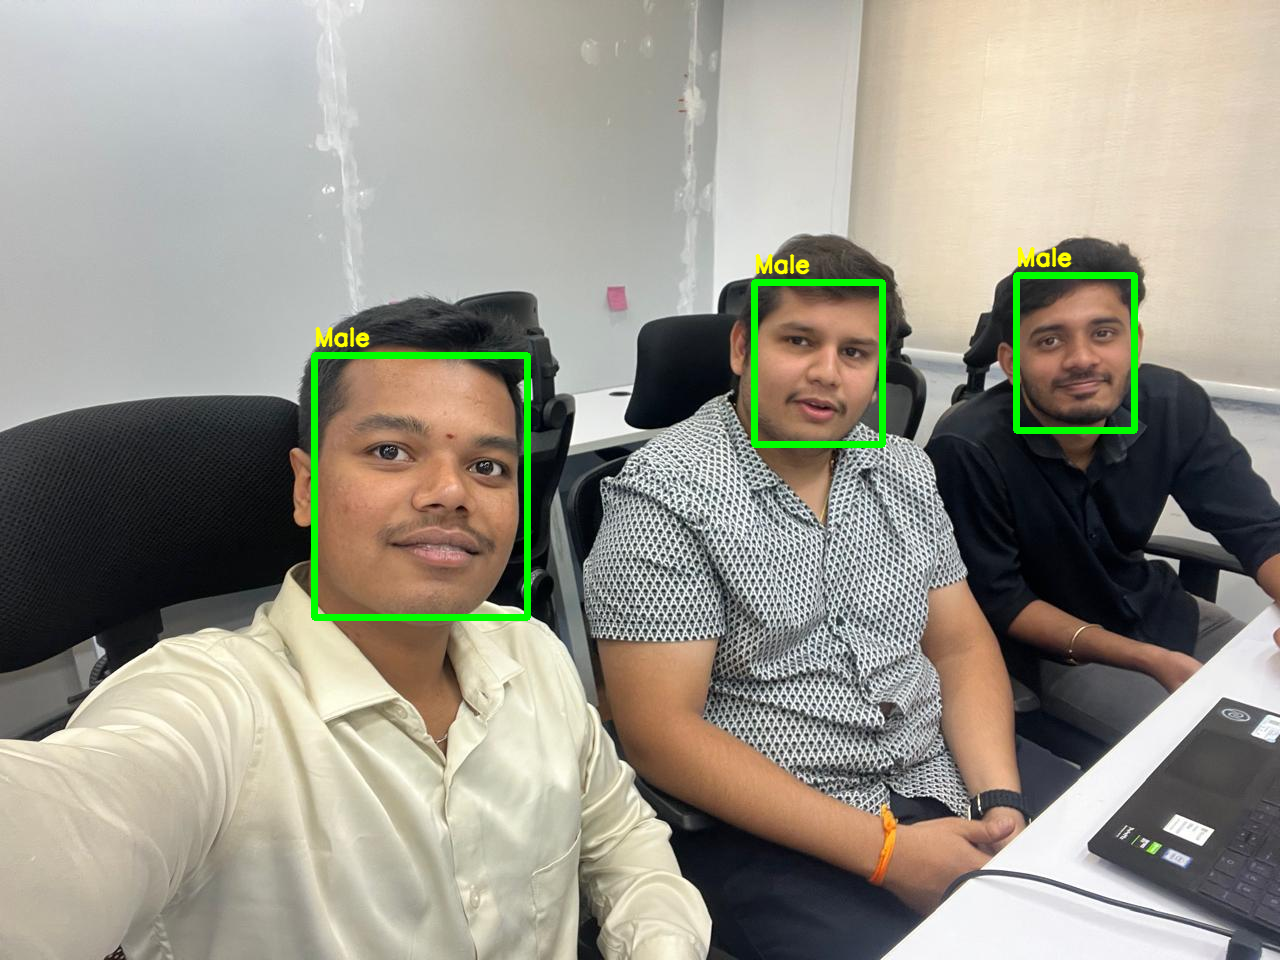

In [ ]:
input = cv.imread("/content/age_and_gender_detection/im1.jpg")
output = gender_detector(input)
cv2_imshow(output)

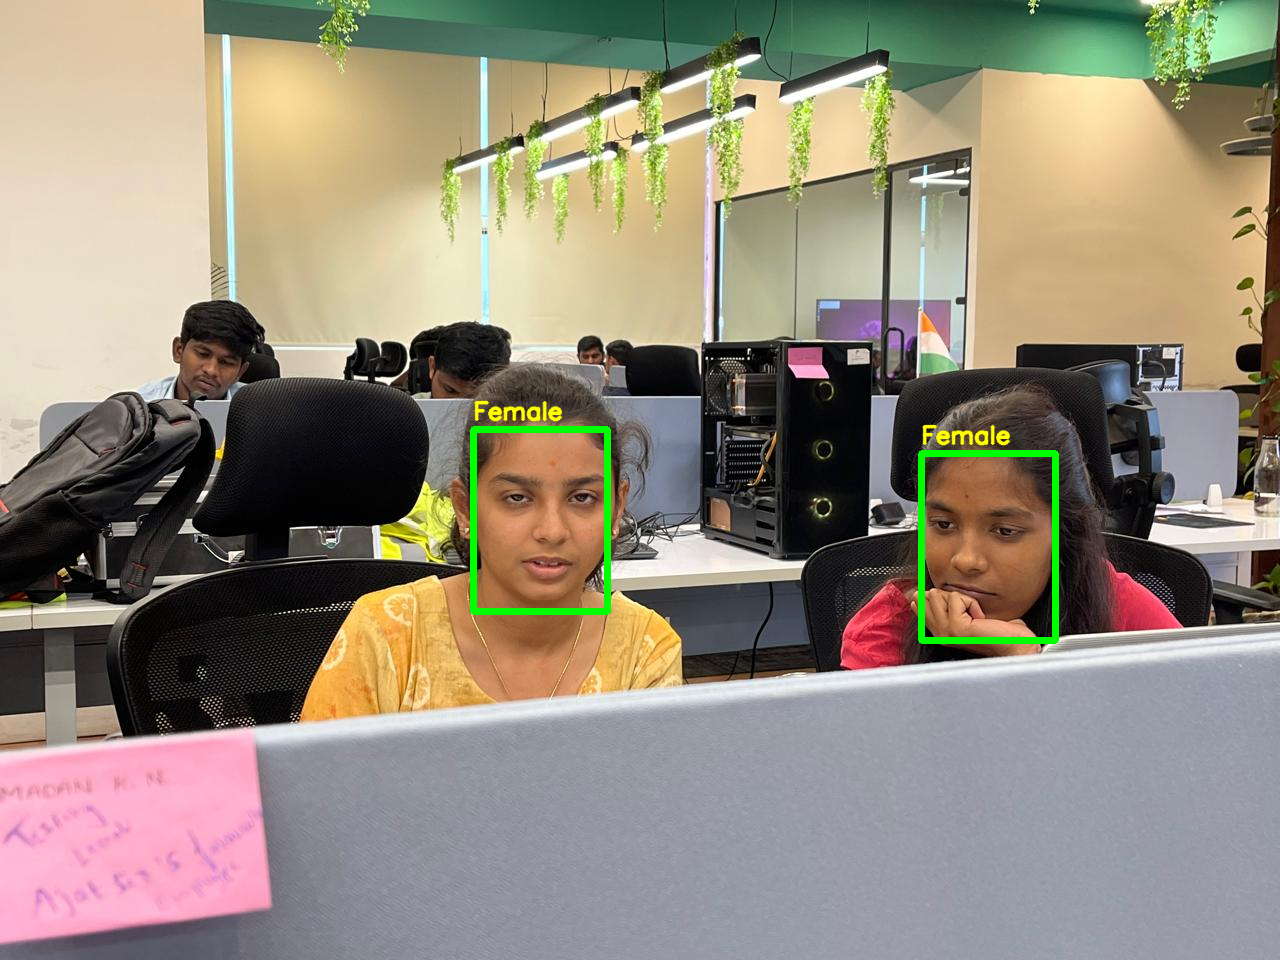

Total Male Count: 0
Total Female Count: 2


In [ ]:
input = cv.imread("/content/age_and_gender_detection/im2.jpg")
output = gender_detector(input)
cv2_imshow(output)
print(f"Total Male Count: {male_count}")
print(f"Total Female Count: {female_count}")

In [ ]:
import cv2
cap = cv2.VideoCapture('/content/v1.mp4')
ret, frame = cap.read()
frame_width= int(cap.get(3))
frame_height= int(cap.get(4))
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
print("Processing Video...")
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  output = gender_detector(frame)
  out.write(output)
out.release()
print("Done processing video")
print(f"Total Male Count: {male_count}")
print(f"Total Female Count: {female_count}")

Processing Video...
Done processing video
Total Male Count: 3
Total Female Count: 0
